# Study on Borrower Reliability
The client is a bank's credit department. The task is to understand whether a client's marital status and number of children affect the repayment of loans on time. The input data from the bank is statistics on clients' solvency.

The results of the study will be taken into account when building a credit scoring model — a special system that assesses the ability of a potential borrower to repay a loan to the bank.

The purpose of the study is to preprocess the data and answer the following questions:

* Is there a correlation between having children and repaying a loan on time?
* Is there a correlation between marital status and repaying a loan on time?
* Is there a correlation between income level and repaying a loan on time?
* How do different loan purposes affect repayment on time?

## Opening and Reviewing the Data
To begin the investigation, it is necessary to study general information about the potential borrowers' data.

To get a complete picture of the data, it is first necessary to import the pandas library and install additional libraries.

In [ ]:
!pip install nltk

In [116]:
#Importing the pandas library
import pandas as pd
#Importing matplotlib.pyplot library for plotting
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Download necessary NLTK data
nltk.download('wordnet')

# Importing the collections module from the Counter library
from collections import Counter

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ivanmakarov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Opening the data file using the try-except method for file paths (in case the file is loaded locally).

We will study the first ten rows of the table to familiarize ourselves with the data.

In [68]:
#Opening the file using the try-except method
try:
    df = pd.read_csv('new_translated_data.csv')
except:
    print('The required file does not exist!')
    
display(df.head(10))    

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,higher,0,married,0,F,employee,0,253875.639453,home purchase
1,1,-4024.803754,36,average,1,married,0,F,employee,0,112080.014102,purchasing a car
2,0,-5623.422610,33,Average,1,married,0,M,employee,0,145885.952297,home purchase
3,3,-4124.747207,32,average,1,married,0,M,employee,0,267628.550329,additional education
4,0,340266.072047,53,average,1,civil marriage,1,F,pensioner,0,158616.077870,get married
5,0,-926.185831,27,higher,0,civil marriage,1,M,companion,0,255763.565419,home purchase
6,0,-2879.202052,43,higher,0,married,0,F,companion,0,240525.971920,housing transactions
7,0,-152.779569,50,AVERAGE,1,married,0,M,employee,0,135823.934197,education
8,2,-6929.865299,35,HIGHER,0,civil marriage,1,F,employee,0,95856.832424,for a wedding
9,0,-2188.756445,41,average,1,married,0,M,employee,0,144425.938277,buying a home for a family


And also get full information about the whole table.

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


This table has 12 columns. Various data types are represented: 5 data types of int64, 2 types of float64, and 5 types of object.

According to the data documentation:

* `children` — the number of children in the family;
* `days_employed` — total employment duration in days;
* `dob_years` — client's age in years;
* `education` — client's education level;
* `education_id` — identifier of the education level;
* `family_status` — marital status;
* `family_status_id` — identifier of marital status;
* `gender` — client's gender;
* `income_type` — type of employment;
* `debt` — whether the client had debts on loans;
* `total_income` — monthly income;
* `purpose` — the purpose of the loan.

As there are missing values in some columns, it's understood that there are some missing values in this data.



**Conclusion**

Each row of the table contains essential parameters that help roughly evaluate a person as a potential client: overall employment duration, monthly income, client's age, presence of debts, and type of employment. The table also presents such data as the number of children in the family, the purpose of the loan, marital status, and the client's education level. These parameters can provide additional information for analysis and answer the question of what can help determine whether a person is capable of repaying a loan on time.

At first glance, it is noticeable that in the columns with the number of children in the family and total employment duration in days, some values are less than zero, and there are discrepancies in the records about the education level with good style. Therefore, to move forward, it is necessary to preprocess the data.

## Data Preprocessing

### Handling Missing Values

First, we need to count how many missing values there are in the table. We can use the `isna()` method for this.

In [70]:
#Counting the number of missing values
df.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

In the `days_employed` and `total_income` columns, you can see the number of missing values. Since not all missing values affect the study, these gaps in the `days_employed` column can be replaced with some explicit notation.

However, the same cannot be done with the `total_income` column, which is one of the main parameters in the higher questions. In reality, it would be good to establish the reason for the gaps and restore the data. But we don't have that opportunity, so we need to fill these gaps with explicit notations as well, and also assess how much they will damage the calculations.


To correct "negative" values where they shouldn't be, we'll use the `mask()` function.

In [71]:
#In the function's condition, we check if the element in the 'days_employed' column is negative,
#then we rewrite it to the opposite
df['days_employed'] = df['days_employed'].mask(df['days_employed'] < 0, -(df['days_employed']))
display(df)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.673028,42,higher,0,married,0,F,employee,0,253875.639453,home purchase
1,1,4024.803754,36,average,1,married,0,F,employee,0,112080.014102,purchasing a car
2,0,5623.422610,33,Average,1,married,0,M,employee,0,145885.952297,home purchase
3,3,4124.747207,32,average,1,married,0,M,employee,0,267628.550329,additional education
4,0,340266.072047,53,average,1,civil marriage,1,F,pensioner,0,158616.077870,get married
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,4529.316663,43,average,1,civil marriage,1,F,companion,0,224791.862382,housing transactions
21521,0,343937.404131,67,average,1,married,0,F,pensioner,0,155999.806512,car deal
21522,1,2113.346888,38,average,1,civil marriage,1,M,employee,1,89672.561153,real estate
21523,3,3112.481705,38,average,1,married,0,M,employee,1,244093.050500,to buy your car


Next, we will use the `median()` method to fill in the gaps with the median value for the column.

In [72]:
#Filling gaps with the median value of the 'days_employed' column
df['days_employed'] = df['days_employed'].fillna(df['days_employed'].median())

Filling missing values in the `total_income` column with the `median()` method is not so suitable because monthly income can depend on many parameters. To minimize the impact of missing values on the research result, you can group data by education level and employment type, and then find the average value.

In [73]:
#Filling gaps with the average value of the 'total_income' column
df['total_income'] = df['total_income'].fillna(df.groupby(['education','income_type'])['total_income'].transform('mean'))

Let's check if there are still any gaps in the table.

In [74]:
#Counting gaps
df.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

It's a good way to fill in the gaps based on groups within our data as this way, we are pinpointing an increase in the level of dispersion.

Although we managed to fill in the gaps, we need to check the other columns for incorrect values. Perhaps there is a negative number of children in the family somewhere, or different fonts are used in different rows.

To search for incorrect values in the other columns, we will use the `value_counts()` method.

In [75]:
#Checking for incorrect values in the 'children' column
df['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

The table has sneaked in 47 "negative" children. Since 47 people out of 21525 clients make up about 0.2%, we will replace the number of these children with an absolute value by modulus.

In [76]:
#In the function's condition, we check if the element in the 'children' column is negative,
#then we rewrite it to the opposite
df['children'] = df['children'].mask(df['children'] < 0, -(df['children']))
#Checking for incorrect values in the 'children' column
df['children'].value_counts()

0     14149
1      4865
2      2055
3       330
20       76
4        41
5         9
Name: children, dtype: int64

The "negative" children have turned into "positive" ones, and we can move on to processing other columns.

In [77]:
#Checking for incorrect values in the 'dob_years' column
df['dob_years'].value_counts()

35    617
40    609
41    607
34    603
38    598
42    597
33    581
39    573
31    560
36    555
44    547
29    545
30    540
48    538
37    537
50    514
43    513
32    510
49    508
28    503
45    497
27    493
56    487
52    484
47    480
54    479
46    475
58    461
57    460
53    459
51    448
59    444
55    443
26    408
60    377
25    357
61    355
62    352
63    269
64    265
24    264
23    254
65    194
22    183
66    183
67    167
21    111
0     101
68     99
69     85
70     65
71     58
20     51
72     33
19     14
73      8
74      6
75      1
Name: dob_years, dtype: int64

The `dob_years` column tells us that the table includes 101 clients aged 0 years. Since the values of this column will not be used in further responses to questions, we will fill them with the average value.

In [78]:
#Finding the average age value in the column
mean_value = df['dob_years'].median()
#We will use a lambda function with the condition 
#that if the age is less than zero, then replace 
#it with the average value
df['dob_years'] = df.dob_years.apply(lambda i : i if i > 0 else mean_value)
df['dob_years'].value_counts()

42.0    698
35.0    617
40.0    609
41.0    607
34.0    603
38.0    598
33.0    581
39.0    573
31.0    560
36.0    555
44.0    547
29.0    545
30.0    540
48.0    538
37.0    537
50.0    514
43.0    513
32.0    510
49.0    508
28.0    503
45.0    497
27.0    493
56.0    487
52.0    484
47.0    480
54.0    479
46.0    475
58.0    461
57.0    460
53.0    459
51.0    448
59.0    444
55.0    443
26.0    408
60.0    377
25.0    357
61.0    355
62.0    352
63.0    269
64.0    265
24.0    264
23.0    254
65.0    194
22.0    183
66.0    183
67.0    167
21.0    111
68.0     99
69.0     85
70.0     65
71.0     58
20.0     51
72.0     33
19.0     14
73.0      8
74.0      6
75.0      1
Name: dob_years, dtype: int64

The age has now become a `float` type, but this is not a problem as the conversion from float to integer type is ahead.

We check the `education` column.

In [79]:
df['education'].value_counts()

average                        13750
higher                          4718
AVERAGE                          772
Average                          711
incomplete higher education      668
HIGHER                           274
Higher                           268
initial                          250
Incomplete higher education       47
INCOMPLETE HIGHER EDUCATION       29
INITIAL                           17
Initial                           15
academic degree                    4
Academic degree                    1
ACADEMIC DEGREE                    1
Name: education, dtype: int64

It can be seen that different font sizes are used in some places, so we will standardize everything using the `str.lower()` method.

In [80]:
#Checking for incorrect values in the 'education' column
df['education'] = df['education'].str.lower()
df['education'].value_counts()

average                        15233
higher                          5260
incomplete higher education      744
initial                          282
academic degree                    6
Name: education, dtype: int64

In [81]:
#Checking for incorrect values in the 'education_id' column
df['education_id'].value_counts()

1    15233
0     5260
2      744
3      282
4        6
Name: education_id, dtype: int64

In [82]:
#Checking for incorrect values in the 'family_status' column
df['family_status'].value_counts()

married               12380
civil marriage         4177
Single/not married     2813
divorced               1195
widower/widow           960
Name: family_status, dtype: int64

In the `family_status` column, we also standardize everything to one font size using the `str.lower()` method.

In [83]:
#Standardizing all fonts to one size
df['family_status'] = df['family_status'].str.lower()
df['family_status'].value_counts()

married               12380
civil marriage         4177
single/not married     2813
divorced               1195
widower/widow           960
Name: family_status, dtype: int64

In [84]:
#Checking for incorrect values in the 'family_status_id' column
df['family_status_id'].value_counts()

0    12380
1     4177
4     2813
3     1195
2      960
Name: family_status_id, dtype: int64

In [85]:
#Checking for incorrect values in the 'gender' column
df['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

In [86]:
#Checking for incorrect values in the 'income_type' column
df['income_type'].value_counts()

employee              11119
companion              5085
pensioner              3856
civil servant          1459
unemployed                2
entrepreneur              2
a student                 1
on maternity leave        1
Name: income_type, dtype: int64

In [87]:
#Checking for incorrect values in the 'debt' column
df['debt'].value_counts()

0    19784
1     1741
Name: debt, dtype: int64

In [88]:
#Checking for incorrect values in the 'total_income' column - income cannot be negative
df[df['total_income'] <0].count()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

In [89]:
#Checking for incorrect values in the 'purpose' column
df['purpose'].value_counts()

wedding                                 797
for a wedding                           777
get married                             774
real estate transactions                676
purchase of commercial real estate      664
housing transactions                    653
buying a rental property                653
commercial real estate transactions     651
home purchase                           647
housing                                 647
buying a home for a family              641
construction of your own real estate    635
real estate                             634
residential real estate construction    626
buying a property                       624
real estate construction                620
buying your own home                    620
home renovation                         612
purchase of residential property        607
operations with your real estate        535
to buy your car                         505
pursue higher education                 496
automobile                      

**Conclusion**

The only columns with missing data were `days_employed` and `total_income`. While the first column's missing values could be filled with obvious ones, the second has the risk that such filling can significantly affect analysis results and distort real outcomes. To minimize this risk, it was decided to group the data by education level and type of activity and find the average value.

Also, the following columns were processed:

* in the `children` column, 47 "negative" children were identified and taken by modulus;
* in the `dob_years` column, 101 people were found to be 0 years old. Since the values of this column will not be used in further conclusions, we simply replaced them with the average value for the column;
* in the `education` and `family_status` columns, there were differences in font sizes, so all entries were standardized to a single size;

There were no discrepancies in the remaining columns, so we can move on to the next stage of data processing.

###  Data Type Replacement

Let's look at the information about the table as a whole because there could have been changes after processing the gaps.

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  float64
 2   dob_years         21525 non-null  float64
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(3), int64(4), object(5)
memory usage: 2.0+ MB


Indeed, instead of two data types `float64`, now there are 3. To replace the floating-point data type with an integer, we will use the `astype()` function and call the table information again.

In [91]:
#Function to convert floating-point values to integers
def convert_to_int (value):
    df[value] = df[value].astype('int')
convert_to_int('days_employed')
convert_to_int('dob_years')
convert_to_int('total_income')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21525 non-null  int64 
 1   days_employed     21525 non-null  int64 
 2   dob_years         21525 non-null  int64 
 3   education         21525 non-null  object
 4   education_id      21525 non-null  int64 
 5   family_status     21525 non-null  object
 6   family_status_id  21525 non-null  int64 
 7   gender            21525 non-null  object
 8   income_type       21525 non-null  object
 9   debt              21525 non-null  int64 
 10  total_income      21525 non-null  int64 
 11  purpose           21525 non-null  object
dtypes: int64(7), object(5)
memory usage: 2.0+ MB


**Вывод**

Conclusion:
After converting floating-point values to integers, we are left with 7 parameters of type `int64` and 5 parameters of type `object`.

<div class="alert alert-success">

We can also apply the `fillna` and `astype` methods to multiple columns at the same time.

If there are more than 2 columns, it's recommended to use a `for` loop.

Example:
    
`df.astype({ "col1": "float64", "col2": "int64"})`
    
</div>

```python

columns = [col1, col2, col3]

for i in columns:
    df[i] = df[i].fillna(0)

```

###  Duplicate Processing

First, let's count the number of explicit duplicates.

In [92]:
#Counting explicit duplicates
df.duplicated().sum()

53

Let's delete the duplicates and count their number in the table again.

In [93]:
# Removing explicit duplicates (with old indexes removed and new ones formed)
df = df.drop_duplicates().reset_index(drop=True)
# Check for no duplicates
df.duplicated().sum()

0

Now let's look for implicit duplicates in the `purpose` column.

In [94]:
# Searching for implicit duplicates
purpose_column = df['purpose'].sort_values().unique()
purpose_column

array(['additional education', 'automobile', 'buying a home for a family',
       'buying a property', 'buying a rental property',
       'buying your own home', 'car deal', 'cars',
       'commercial real estate transactions',
       'construction of your own real estate', 'education',
       'engage in education', 'for a wedding', 'get married',
       'getting an education', 'higher education', 'home purchase',
       'home renovation', 'housing', 'housing transactions',
       'obtaining additional education', 'obtaining higher education',
       'operations with your real estate',
       'purchase of commercial real estate',
       'purchase of residential property', 'purchasing a car',
       'pursue higher education', 'real estate',
       'real estate construction', 'real estate transactions',
       'residential real estate construction', 'specialized education',
       'to buy a car', 'to buy a used car', 'to buy your car',
       'transactions with your real estate', 'used c

**Conclusion:**

1. Explicit duplicates were removed with the deletion of old indexes and the appearance of new ones. The appearance of duplicates can be justified by an error in data unloading or human factor.

2. According to the table, you can identify 4 main purposes of getting a loan:

* `Real Estate`;
* `Automobiles`;
* `Education`;
* `Weddings`.

We can replace all positions using `replace()`, but listing all duplicates can take a lot of time. Everyone forms their goals differently, as there is no single rule for writing credit goals. Therefore, it's better to leave them as they are and process them through lemmatization.

### Lemmatization

We will identify the lemmas in the values of the column with the purposes of obtaining credit.

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


In [96]:


# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to convert a part of speech tag into a wordnet tag
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Lemmatize each purpose description
for i in range(df.shape[0]):
    # Tokenize the sentence into words and part-of-speech tag each word
    tokens = nltk.pos_tag(nltk.word_tokenize(df['purpose'][i]))
    # Lemmatize each word with the appropriate POS tag
    lemmas = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tokens
    ]
    # Save the list of lemmas back as a string
    df.loc[i, 'lemmas'] = ' '.join(lemmas)

# Display the data
display(df.head(15))


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ivanmakarov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,lemmas
0,1,8437,42,higher,0,married,0,F,employee,0,253875,home purchase,home purchase
1,1,4024,36,average,1,married,0,F,employee,0,112080,purchasing a car,purchase a car
2,0,5623,33,average,1,married,0,M,employee,0,145885,home purchase,home purchase
3,3,4124,32,average,1,married,0,M,employee,0,267628,additional education,additional education
4,0,340266,53,average,1,civil marriage,1,F,pensioner,0,158616,get married,get married
5,0,926,27,higher,0,civil marriage,1,M,companion,0,255763,home purchase,home purchase
6,0,2879,43,higher,0,married,0,F,companion,0,240525,housing transactions,housing transaction
7,0,152,50,average,1,married,0,M,employee,0,135823,education,education
8,2,6929,35,higher,0,civil marriage,1,F,employee,0,95856,for a wedding,for a wedding
9,0,2188,41,average,1,married,0,M,employee,0,144425,buying a home for a family,buy a home for a family


Let's identify the most common lemmas for creating "dictionaries."

In [98]:
#Creating a variable common_lemmas, where unique values from
#the 'lemmas' column are stored, converted into a string, 
#and then the most frequent words are counted
common_lemmas = Counter(m.lemmatize(str(df['lemmas'].unique()))).most_common()
common_lemmas

[(' ', 79),
 ("' '", 24),
 ("'\n", 14),
 (" '", 14),
 ('education', 9),
 ('real', 9),
 ('estate', 9),
 ('a', 8),
 ('car', 8),
 ('buy', 7),
 ('your', 6),
 ('home', 4),
 ('purchase', 4),
 ('transaction', 4),
 ('property', 3),
 ('of', 3),
 ('construction', 3),
 ('to', 3),
 ('high', 3),
 ('additional', 2),
 ('get', 2),
 ('housing', 2),
 ('for', 2),
 ('wedding', 2),
 ('commercial', 2),
 ('residential', 2),
 ('own', 2),
 ('used', 2),
 ('with', 2),
 ('deal', 2),
 ('obtain', 2),
 ("['", 1),
 ('married', 1),
 ('family', 1),
 ('operation', 1),
 ('engage', 1),
 ('in', 1),
 ('an', 1),
 ('automobile', 1),
 ('specialized', 1),
 ('rental', 1),
 ('renovation', 1),
 ('pursue', 1),
 ("']\n", 1)]

**Conclusion**

Our hypothesis in the section searching for implicit duplicates was confirmed; the most popular lemmas are:

* real estate/housing
* car
* education
* as well as weddings and renovations, although they are few in the list of unique values: if we sample all values, the credit goals related to weddings and renovations will not be in the last place.

### Data Categorization

Since the main task is to find answers to questions related to parameters such as:

* the presence of children;
* marital status;
* income level;
* purpose of the loan,

it's necessary to categorize these data.

Marital status and the presence of children don't have many unique values, so they can easily be summarized in a table. However, income level and loan purposes need to be categorized due to the large number of values.

To categorize the `total_income` column, we need to find the maximum and minimum income in the column and then divide them into conditional groups for clarity.

In [99]:
# Finding the maximum income
df.loc[df['total_income'].idxmax()]

children                          0
days_employed                  1477
dob_years                        44
education                    higher
education_id                      0
family_status               married
family_status_id                  0
gender                            M
income_type               companion
debt                              0
total_income                2265604
purpose             home renovation
lemmas              home renovation
Name: 12397, dtype: object

In [100]:
#Finding the minimum income
df.loc[df['total_income'].idxmin()]

children                      0
days_employed            359219
dob_years                    57
education               average
education_id                  1
family_status           married
family_status_id              0
gender                        F
income_type           pensioner
debt                          1
total_income              20667
purpose             real estate
lemmas              real estate
Name: 14563, dtype: object

The range of values is approximately `2,000,000` units, so we'll divide incomes into levels: low, below average, average, above average, high, very high.

In [101]:
# Declaration of function with income parameter
def income_func(income):
    if income <= 50000:
        return 'low'
    elif income <= 80000:
        return 'below average'
    elif income <= 100000:
        return 'average'
    elif income <= 250000:
        return 'above average'
    elif income <= 500000:
        return 'high'
    return 'very high'
#Apply the function to 'total_income' and add new values to the 'income_category' column
df['income_category'] = df['total_income'].apply(income_func)

We will also categorize the `lemmas` column to make it easier to see the dependency.

In [103]:
df['lemmas'].unique()

array(['home purchase', 'purchase a car', 'additional education',
       'get married', 'housing transaction', 'education', 'for a wedding',
       'buy a home for a family', 'buy a property',
       'purchase of commercial real estate',
       'purchase of residential property',
       'construction of your own real estate', 'real estate',
       'real estate construction', 'to buy a used car', 'to buy your car',
       'commercial real estate transaction',
       'residential real estate construction', 'housing',
       'operation with your real estate', 'car', 'engage in education',
       'used car deal', 'get an education', 'automobile', 'wedding',
       'obtain additional education', 'buy your own home',
       'real estate transaction', 'obtain high education', 'your car',
       'car deal', 'specialized education', 'high education',
       'buy a rental property', 'to buy a car', 'home renovation',
       'pursue high education', 'transaction with your real estate'],
      dty

In [39]:
#Создаем переменную для списка лемм из столбца 'lemmas'
list_of_new_lemmas = []
#Присваиваем переменной list_of_new_lemmas столбец 'lemmas', преобразованный в тип list
list_of_new_lemmas = list(df['lemmas'])
#Создаем цикл по всем значениям списка list_of_new_lemmas
for index in range(len(list_of_new_lemmas)):
    #Проверяем, если есть такое значение в нашем списке
    if ('автомобил' in list_of_new_lemmas[index]):
        #Добавляем это значение в новый столбец 'type_of_purpose' с новым названием
        df.loc[index,'type_of_purpose'] = 'автомобиль'
    elif ('недвижимост' in list_of_new_lemmas[index]) |  ('жиль' in list_of_new_lemmas[index]) :
        df.loc[index,'type_of_purpose'] = 'недвижимость'
    elif ('свадьб' in list_of_new_lemmas[index]):
        df.loc[index,'type_of_purpose'] = 'свадьба'
    elif ('образовани' in list_of_new_lemmas[index]):
        df.loc[index,'type_of_purpose'] = 'образование'
    else:
        df.loc[index,'type_of_purpose'] = 'None'
#Проверяем, как теперь выглядит таблица        
display(df.tail(20))

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,lemmas,income_category,type_of_purpose
21450,0,338904,53,среднее,1,гражданский брак,1,M,пенсионер,0,75439,сыграть свадьбу,сыграть свадьба\n,ниже среднего,свадьба
21451,1,1556,33,высшее,0,гражданский брак,1,F,сотрудник,0,145541,свадьба,свадьба\n,выше среднего,свадьба
21452,1,79,32,среднее,1,гражданский брак,1,F,госслужащий,0,98180,сделка с подержанным автомобилем,сделка с подержанный автомобиль\n,средний,автомобиль
21453,0,386497,62,среднее,1,женат / замужем,0,M,пенсионер,0,72638,недвижимость,недвижимость\n,ниже среднего,недвижимость
21454,0,362161,59,высшее,0,женат / замужем,0,M,пенсионер,0,73029,операции с недвижимостью,операция с недвижимость\n,ниже среднего,недвижимость
21455,2,2194,28,среднее,1,женат / замужем,0,F,сотрудник,0,152894,приобретение автомобиля,приобретение автомобиль\n,выше среднего,автомобиль
21456,0,612,29,высшее,0,гражданский брак,1,F,сотрудник,1,140068,покупка жилья для сдачи,покупка жилье для сдача\n,выше среднего,недвижимость
21457,0,165,26,высшее,0,не женат / не замужем,4,M,компаньон,0,147301,получение дополнительного образования,получение дополнительный образование\n,выше среднего,образование
21458,0,1166,35,среднее,1,женат / замужем,0,F,сотрудник,0,250986,покупка жилья,покупка жилье\n,высокий,недвижимость
21459,0,280,27,неоконченное высшее,2,не женат / не замужем,4,M,компаньон,0,355988,строительство недвижимости,строительство недвижимость\n,высокий,недвижимость


In [114]:
# Create a variable for a list of lemmas from the 'lemmas' column
list_of_new_lemmas = []
# Assign the 'lemmas' column, converted to a list type, to the variable list_of_new_lemmas
list_of_new_lemmas = list(df['lemmas'])
# Create a loop over all values in the list_of_new_lemmas
for index in range(len(list_of_new_lemmas)):
    # Check if such a value is in our list
    if 'car' in list_of_new_lemmas[index] or 'automobile' in list_of_new_lemmas[index]: 
        # Add this value to the new column 'type_of_purpose' with a new name
        df.loc[index, 'type_of_purpose'] = 'car'
    elif 'real estate' in list_of_new_lemmas[index] or 'housing' in list_of_new_lemmas[index] or 'home' in list_of_new_lemmas[index] or 'property' in list_of_new_lemmas[index]:
        df.loc[index, 'type_of_purpose'] = 'real estate'
    elif 'wedding' in list_of_new_lemmas[index] or 'marri' in list_of_new_lemmas[index]:
        df.loc[index, 'type_of_purpose'] = 'wedding'
    elif 'education' in list_of_new_lemmas[index]:
        df.loc[index, 'type_of_purpose'] = 'education'
    else:
        df.loc[index, 'type_of_purpose'] = 'None'
# Check what the table looks like now        
display(df.tail(20))


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,lemmas,income_category,type_of_purpose
21452,0,338904,53,average,1,civil marriage,1,M,pensioner,0,75439,get married,get married,below average,wedding
21453,1,1556,33,higher,0,civil marriage,1,F,employee,0,145541,wedding,wedding,above average,wedding
21454,1,79,32,average,1,civil marriage,1,F,civil servant,0,98180,used car deal,used car deal,average,car
21455,0,386497,62,average,1,married,0,M,pensioner,0,72638,real estate,real estate,below average,real estate
21456,0,362161,59,higher,0,married,0,M,pensioner,0,73029,real estate transactions,real estate transaction,below average,real estate
21457,2,2194,28,average,1,married,0,F,employee,0,152894,purchasing a car,purchase a car,above average,car
21458,0,612,29,higher,0,civil marriage,1,F,employee,1,140068,buying a rental property,buy a rental property,above average,real estate
21459,0,165,26,higher,0,single/not married,4,M,companion,0,147301,obtaining additional education,obtain additional education,above average,education
21460,0,1166,35,average,1,married,0,F,employee,0,250986,home purchase,home purchase,high,real estate
21461,0,280,27,incomplete higher education,2,single/not married,4,M,companion,0,355988,real estate construction,real estate construction,high,real estate


**Вывод**

В ходе выполнения пункта 2.5 были выделены следующие словари:

* `income_category`, разделяющий уровень дохода на несколько уровней: низкий, ниже среднего, средний, выше среднего, высокий, очень высокий;
* `type_of_purpose`, разделяющий цели кредита на следующие категории: сделка с автомобилем, сделка с недвижимостью, расходы на свадьбу и расходы на образование

Разделять на уровни столбцы `children` не нужно, так как уникальных значений там немного. То же самое касается стобца `family_status`, которому уже соответсвует столбец `family_status_id` с выделенными категориями.

**Conclusion**

During the execution of item 2.5, the following dictionaries were identified:

* `income_category,` dividing the income level into several levels: low, below average, average, above average, high, very high.
* `type_of_purpose,` dividing the loan purposes into the following categories: car transaction, real estate transaction, wedding expenses, and education expenses.

It's not necessary to divide the `children` column into levels, as there are few unique values there. The same applies to the `family_status` column, which already corresponds to the `family_status_id` column with designated categories.

## Answers to questions

- Is there a correlation between having children and repaying a loan on time?

To answer the question, we can create a pivot table with average values of children relative to loan repayment on time.

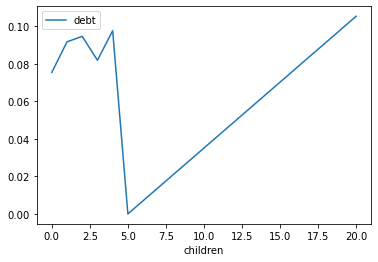

In [117]:
#Строим сводную таблицу по количеству детей и возврату кредита в срок, строим график
data_pivot = df.pivot_table(index='children', values='debt', aggfunc='mean').plot()

**Conclusion**

The table does not show a linear relationship between the number of children and the presence of debts. It can only be said that families with three to five children likely repay loans on time slightly more often than clients with a different number of children.

- Is there a correlation between marital status and repaying a loan on time?

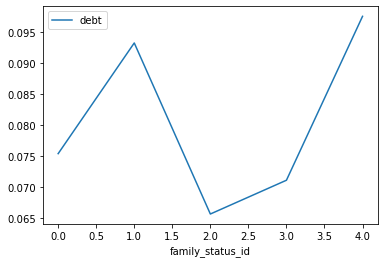

In [118]:
#Building a pivot table based on marital status and loan repayment on time, then plotting it
data_pivot = df.pivot_table(index='family_status_id', values='debt', aggfunc='mean').plot()

**Conclusion**

The chart shows that divorced individuals `(family_status_id = 3)` and widowers/widows `(family_status_id = 2)` have the lowest rates, while single individuals `(family_status_id = 4)` and clients living in civil marriages `(family_status_id = 1)` are more likely not to return the loan on time.

- Is there a correlation between income level and repaying a loan on time?

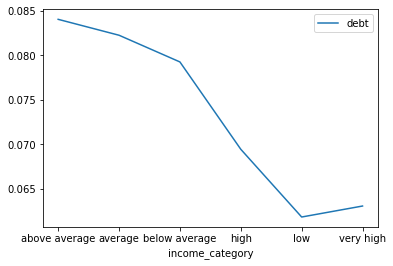

In [119]:
#Building a pivot table based on income level and loan repayment on time, then plotting it
data_pivot = df.pivot_table(index='income_category', values='debt', aggfunc='mean').plot()

**Conclusion**

The chart suggests that clients with low incomes are more willing to return money than people with average and above-average incomes. Clients with high and very high income levels possibly rarely use credit services. However, they can be relied upon when it comes to repaying funds on time.

<div class="alert alert-success">
    
We could also have calculated this using an alternative grouping method, `groupby`.
    
</div>

- How do different loan purposes affect its repayment on time?

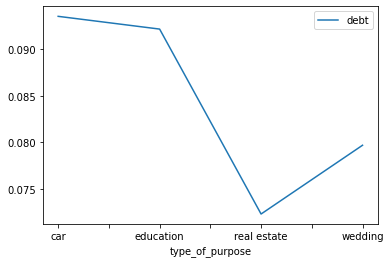

In [120]:
#Building a pivot table based on income level and timely loan repayment, then plotting it
data_pivot = df.pivot_table(index='type_of_purpose', values='debt', aggfunc='mean').plot()

**Conclusion**

The most orderly and responsible clients are those who take out loans for real estate. This may be due to the fact that often people take out a mortgage and this is their only housing. The fear of losing their home may influence the client to conscientiously repay the money to the bank. On the other hand, consumer loans for weddings, cars, and education are not as risky, so clients are less worried about this.

## General Conclusion

By answering 4 questions, it was possible to establish:

1. If a client has children, but not in the number from 3 to 5, there is a probability that they will not be able to repay the loan on time.


2. Clients who are married or those who have ever been in marital relationships approach the issue of lending and timely money return more responsibly than clients who are not in marital relationships or living in civil marriages (which, de facto, is also considered an analogue of free relationships).


3. Clients with low income levels return money on time more often than people with average income and above-average income. Clients with high and very high income levels also repay the borrowed money on time. However, this result could have been different if there had been no gaps in the data.


4. Clients taking out loans for real estate are more willing to return money to the bank than clients who took out loans for weddings, cars, and education.